# Should change Tkf below

In [2]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

# Should change Tkf below

In [3]:
from multi_loc import covariance, assimilate, utilities

In [4]:
%matplotlib inline

In [5]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [6]:
tune_name = 'coarse_obs_R'

save_dir = 'RK_tune'

home = os.path.expanduser('~')

save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)
    
this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [7]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 15.0
b = 10.0
c = 2.5
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.004166666666666667
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


# Should change Tkf below

In [8]:
tune_dir = os.path.join(save_dir, tune_name)
# if not os.path.exists(tune_dir):
#     os.mkdir(tune_dir)

# dt_trial_rk = 0.05/24
# dt_kf = 0.05
# dt_save = None
# Tkf = Tgt/5     ######## Change this (I forgot) #######


# alpha_range = np.array([0, 0.01, 0.02, 0.04, 0.08], dtype='float')
# loc_range = np.array([5, 10, 15, 20, 30, 40, 50, 60], dtype='float')


# R_sd = 2
# everyH = 24
# Hz = np.eye(Nz)[::everyH]
# Ny = Hz.shape[0]
# Rz = np.eye(Ny) * R_sd**2

# fine_obs_dict = {'dt_trial_rk': dt_trial_rk,
#                  'dt_kf': dt_kf,
#                  'dt_save': dt_save,
#                  'Tkf': Tkf,
#                  'Tspin': Tspin,
#                  'alpha_range': alpha_range,
#                  'loc_range': loc_range,
#                  'R_sd': R_sd,
#                  'everyH': everyH,
#                  'Hz': Hz,
#                  'Rz': Rz}

this_path = os.path.join(tune_dir, 'KF_dict.pkl')
with open(this_path, mode='rb') as f:
    fine_obs_dict = pickle.load(f)

In [9]:
for key, value in fine_obs_dict.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

dt_trial_rk = 0.000625
dt_kf = 0.05
dt_save = None
Tkf = 50.0
Tspin = 25.0
alpha_range = [0.   0.08 0.16 0.32 0.64]
loc_range = [1. 2. 3. 4. 5. 6.]
R_sd = 2
everyH = 2
Hz = [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Rz = [[4.         3.99864389 3.99457833 ... 3.98781158 3.99457833 3.99864389]
 [3.99864389 4.         3.99864389 ... 3.97835737 3.98781158 3.99457833]
 [3.99457833 3.99864389 4.         ... 3.9662349  3.97835737 3.98781158]
 ...
 [3.98781158 3.97835737 3.9662349  ... 4.         3.99864389 3.99457833]
 [3.99457833 3.98781158 3.97835737 ... 3.99864389 4.         3.99864389]
 [3.99864389 3.99457833 3.98781158 ... 3.99457833 3.99864389 4.        ]]


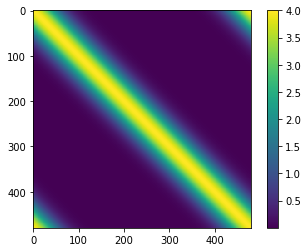

In [10]:
imshow(Rz)

In [11]:
Tspin_index = 500
Tspin = dt_kf * Tspin_index

In [12]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [13]:
Zloc = np.arange(Nz)

this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

Zgt_ts = xr.DataArray(Zgt[:, 0:index_Tkf:every_t],
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
this_path = os.path.join(tune_dir, 'Zobs_ts.nc')
Zobs_ts = xr.open_dataarray(this_path)
del Zgt

In [14]:
smooth_range = np.array([2, 2.5], dtype='float')
coarse_loc_range = np.array([5, 10, 20, 40], dtype='float')
fine_loc_range = np.array([1, 2, 3, 4], dtype='float')
alpha_range = np.array([0.08, 0.16, 0.32, 0.64], dtype='float')
N_laml = 20

In [15]:
print(smooth_range.size*coarse_loc_range.size*fine_loc_range.size*alpha_range.size)

128


In [ ]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([smooth_range.size,
                        fine_loc_range.size,
                        coarse_loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

smooth_dir = os.path.join(tune_dir, 'smooth_loc')
if not os.path.exists(smooth_dir):
    os.mkdir(smooth_dir)
for alpha_count, this_alpha in enumerate(alpha_range):
    for smooth_count, this_smooth in enumerate(smooth_range):
        for fine_loc_count, this_fine_loc in enumerate(fine_loc_range):
            for coarse_loc_count, this_coarse_loc in enumerate(coarse_loc_range):
                this_folder_name = f'inf_{alpha_count:04}_smooth_{smooth_count:04}'
                this_folder_name += f'_floc_{fine_loc_count:04}_cloc_{coarse_loc_count:04}'
                this_dir_name = os.path.join(smooth_dir, this_folder_name)
                if not os.path.exists(this_dir_name):
                    os.mkdir(this_dir_name)
                print('alpha: ', this_alpha, '; smooth: ', this_smooth)
                print('fine_loc: ', this_fine_loc, '; coarse_loc: ', this_coarse_loc)
                print(this_dir_name)

                rho_Zf = np.arange(Nz)
                rho_Zf = np.minimum(np.abs(Nz - rho_Zf)%Nz, rho_Zf)
                rho_Zf = np.exp(-(rho_Zf**2)/(2*this_fine_loc**2))
                rho_Zf = sp.linalg.circulant(rho_Zf)

                rho_Zc = np.arange(Nz)
                rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
                rho_Zc = np.exp(-(rho_Zc**2)/(2*this_coarse_loc**2))
                rho_Zc = sp.linalg.circulant(rho_Zc)

                this_path = os.path.join(this_dir_name, 'rho0f')
                np.save(this_path, this_fine_loc)

                this_path = os.path.join(this_dir_name, 'rho0c')
                np.save(this_path, this_coarse_loc)

                this_path = os.path.join(this_dir_name, 'alpha')
                np.save(this_path, this_alpha)

                this_path = os.path.join(this_dir_name, 'smooth')
                np.save(this_path, this_smooth)

                this_path = os.path.join(this_dir_name, 'N_laml')
                np.save(this_path, N_laml)

                cycle_dict = {'Z0ens': Z0ens,
                              'Zobs_ts': Zobs_ts,
                              'Rz': Rz, 'Hz': Hz,
                              'Tkf': Tkf,
                              'dt_kf': dt_kf,
                              'dt_rk': dt_trial_rk,
                              'rho_Zc': rho_Zc,
                              'rho_Zf': rho_Zf,
                              'N_laml': N_laml,
                              'smooth_len': this_smooth,
                              'alpha': this_alpha}
                try:
                    returned_dict = assimilate.cycle_KF_LM3_smooth(**cycle_dict)
                    mu_f = returned_dict['mu_f']
                    std_f = returned_dict['std_f']

                    mu_a = returned_dict['mu_a']
                    std_a = returned_dict['std_a']

                    this_path = os.path.join(this_dir_name, 'mu_f.nc')
                    mu_f.to_netcdf(this_path)

                    this_path = os.path.join(this_dir_name, 'std_f.nc')
                    std_f.to_netcdf(this_path)

                    this_path = os.path.join(this_dir_name, 'mu_a.nc')
                    mu_a.to_netcdf(this_path)

                    this_path = os.path.join(this_dir_name, 'std_a.nc')
                    std_a.to_netcdf(this_path)


                    rmse_array_f[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
                        ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
                    rmse_array_a[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
                        ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
                    std_array_f[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_f**2).mean(axis=0))
                                                          .isel(time=slice(Tspin_index, None)).mean())
                    std_array_a[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_a**2).mean(axis=0))
                                                          .isel(time=slice(Tspin_index, None)).mean())
                    print('rmse_f: ', rmse_array_f[alpha_count, fine_loc_count, coarse_loc_count])
                    print('rmse_a: ', rmse_array_a[alpha_count, fine_loc_count, coarse_loc_count])

                except:
                    print(this_dir_name, ' has failed.')

alpha:  0.08 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0000_cloc_0000
rmse_f:  5.035195622223291
rmse_a:  5.00471242294352
alpha:  0.08 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0000_cloc_0001
rmse_f:  0.0020908242325014337
rmse_a:  0.0016558052604555265
alpha:  0.08 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0000_cloc_0002


/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:370: RuntimeWarning: overflow encountered in multiply
  T1 = -1 * np.roll(W, 2 * K, axis=0) * np.roll(W, K, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:371: RuntimeWarning: overflow encountered in multiply
  WX = np.roll(W, K, axis=0) * np.roll(X, -K, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:373: RuntimeWarning: invalid value encountered in add
  return T1 + T2
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:356: RuntimeWarning: overflow encountered in multiply
  T1 = -1 * np.roll(X, 2, axis=0) * np.roll(X, 1, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:357: RuntimeWarning: overflow encountered in multiply
  T2 = np.roll(X, 1, axis=0) * np.roll(X, -1, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:358: RuntimeWarning: invalid value encountered in add
  return T1 + T2
/Users

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0000_cloc_0002  has failed.
alpha:  0.08 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0000_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0000_cloc_0003  has failed.
alpha:  0.08 ; smooth:  2.0
fine_loc:  2.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0001_cloc_0000
rmse_f:  0.0018437939788315517
rmse_a:  0.0014944889488268816
alpha:  0.08 ; smooth:  2.0
fine_loc:  2.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0001_cloc_0001
rmse_f:  4.332524123768891
rmse_a:  4.309473376823937
alpha:  0.08 ; smooth:  2.0
fi

/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:358: RuntimeWarning: overflow encountered in add
  return T1 + T2
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:348: RuntimeWarning: overflow encountered in add
  return T1 + T2


/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0001_cloc_0002  has failed.
alpha:  0.08 ; smooth:  2.0
fine_loc:  2.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0001_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0001_cloc_0003  has failed.
alpha:  0.08 ; smooth:  2.0
fine_loc:  3.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0002_cloc_0000
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0002_cloc_0000  has failed.
alpha:  0.08 ; smooth:  2.0
fine_loc:  3.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_0000_floc_0002_cloc_0001
/User

rmse_f:  0.2508238241901497
rmse_a:  0.19229749403529406
alpha:  0.16 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0000_floc_0000_cloc_0001
rmse_f:  0.017424992422127417
rmse_a:  0.012459309958684089
alpha:  0.16 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0000_floc_0000_cloc_0002
rmse_f:  0.00168154078473356
rmse_a:  0.0013575056095232513
alpha:  0.16 ; smooth:  2.0
fine_loc:  1.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0000_floc_0000_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0000_floc_0000_cloc_0003  has failed.
alpha:  0.16 ; smooth:  2.0
fine_loc:  2.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/no

/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:305: RuntimeWarning: overflow encountered in add
  dZdt = T1 + T2 + T3 - X - b*Y + F


/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0001_floc_0000_cloc_0002  has failed.
alpha:  0.16 ; smooth:  2.5
fine_loc:  1.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0001_floc_0000_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0001_floc_0000_cloc_0003  has failed.
alpha:  0.16 ; smooth:  2.5
fine_loc:  2.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0001_floc_0001_cloc_0000
rmse_f:  0.0019668836940357425
rmse_a:  0.0015359799253778803
alpha:  0.16 ; smooth:  2.5
fine_loc:  2.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0001_smooth_0001_floc_0001_cloc_0001
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_l

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_0000_floc_0003_cloc_0001  has failed.
alpha:  0.32 ; smooth:  2.0
fine_loc:  4.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_0000_floc_0003_cloc_0002
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_0000_floc_0003_cloc_0002  has failed.
alpha:  0.32 ; smooth:  2.0
fine_loc:  4.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_0000_floc_0003_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_0000_floc_0003_cloc_0003  has failed.
alpha:  0.32 ; smooth:  2.5
fine_loc:  1.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_0001_floc_0000_cloc_0000
/User

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0000_floc_0001_cloc_0002  has failed.
alpha:  0.64 ; smooth:  2.0
fine_loc:  2.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0000_floc_0001_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0000_floc_0001_cloc_0003  has failed.
alpha:  0.64 ; smooth:  2.0
fine_loc:  3.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0000_floc_0002_cloc_0000
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0000_floc_0002_cloc_0000  has failed.
alpha:  0.64 ; smooth:  2.0
fine_loc:  3.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0000_floc_0002_cloc_0001
/User

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_0001_floc_0003_cloc_0003  has failed.


In [16]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([smooth_range.size,
                        fine_loc_range.size,
                        coarse_loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

smooth_dir = os.path.join(tune_dir, 'smooth_loc')
if not os.path.exists(smooth_dir):
    os.mkdir(smooth_dir)
this_smooth = None
smooth_count = 9999



for alpha_count, this_alpha in enumerate(alpha_range):
#     for smooth_count, this_smooth in enumerate(smooth_range):
    for fine_loc_count, this_fine_loc in enumerate(fine_loc_range):
        for coarse_loc_count, this_coarse_loc in enumerate(coarse_loc_range):
            this_folder_name = f'inf_{alpha_count:04}_smooth_{smooth_count:04}'
            this_folder_name += f'_floc_{fine_loc_count:04}_cloc_{coarse_loc_count:04}'
            this_dir_name = os.path.join(smooth_dir, this_folder_name)
            if not os.path.exists(this_dir_name):
                os.mkdir(this_dir_name)
            print('alpha: ', this_alpha, '; smooth: ', this_smooth)
            print('fine_loc: ', this_fine_loc, '; coarse_loc: ', this_coarse_loc)
            print(this_dir_name)

            rho_Zf = np.arange(Nz)
            rho_Zf = np.minimum(np.abs(Nz - rho_Zf)%Nz, rho_Zf)
            rho_Zf = np.exp(-(rho_Zf**2)/(2*this_fine_loc**2))
            rho_Zf = sp.linalg.circulant(rho_Zf)

            rho_Zc = np.arange(Nz)
            rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
            rho_Zc = np.exp(-(rho_Zc**2)/(2*this_coarse_loc**2))
            rho_Zc = sp.linalg.circulant(rho_Zc)

            this_path = os.path.join(this_dir_name, 'rho0f')
            np.save(this_path, this_fine_loc)

            this_path = os.path.join(this_dir_name, 'rho0c')
            np.save(this_path, this_coarse_loc)

            this_path = os.path.join(this_dir_name, 'alpha')
            np.save(this_path, this_alpha)

            this_path = os.path.join(this_dir_name, 'smooth')
            np.save(this_path, this_smooth)

            this_path = os.path.join(this_dir_name, 'N_laml')
            np.save(this_path, N_laml)

            cycle_dict = {'Z0ens': Z0ens,
                          'Zobs_ts': Zobs_ts,
                          'Rz': Rz, 'Hz': Hz,
                          'Tkf': Tkf,
                          'dt_kf': dt_kf,
                          'dt_rk': dt_trial_rk,
                          'rho_Zc': rho_Zc,
                          'rho_Zf': rho_Zf,
                          'N_laml': N_laml,
                          'smooth_len': this_smooth,
                          'alpha': this_alpha}
            try:
                returned_dict = assimilate.cycle_KF_LM3_smooth(**cycle_dict)
                mu_f = returned_dict['mu_f']
                std_f = returned_dict['std_f']

                mu_a = returned_dict['mu_a']
                std_a = returned_dict['std_a']

                this_path = os.path.join(this_dir_name, 'mu_f.nc')
                mu_f.to_netcdf(this_path)

                this_path = os.path.join(this_dir_name, 'std_f.nc')
                std_f.to_netcdf(this_path)

                this_path = os.path.join(this_dir_name, 'mu_a.nc')
                mu_a.to_netcdf(this_path)

                this_path = os.path.join(this_dir_name, 'std_a.nc')
                std_a.to_netcdf(this_path)


                rmse_array_f[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
                    ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                              .isel(time=slice(Tspin_index, None)).mean())
                rmse_array_a[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
                    ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                              .isel(time=slice(Tspin_index, None)).mean())
                std_array_f[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_f**2).mean(axis=0))
                                                      .isel(time=slice(Tspin_index, None)).mean())
                std_array_a[alpha_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_a**2).mean(axis=0))
                                                      .isel(time=slice(Tspin_index, None)).mean())
                print('rmse_f: ', rmse_array_f[alpha_count, fine_loc_count, coarse_loc_count])
                print('rmse_a: ', rmse_array_a[alpha_count, fine_loc_count, coarse_loc_count])

            except:
                print(this_dir_name, ' has failed.')

alpha:  0.08 ; smooth:  None
fine_loc:  1.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0000_cloc_0000
rmse_f:  0.11671700920476603
rmse_a:  0.08878269654102544
alpha:  0.08 ; smooth:  None
fine_loc:  1.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0000_cloc_0001
rmse_f:  5.476334231269477
rmse_a:  5.462296196346838
alpha:  0.08 ; smooth:  None
fine_loc:  1.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0000_cloc_0002
rmse_f:  2.9536064898259218
rmse_a:  2.926727512717271
alpha:  0.08 ; smooth:  None
fine_loc:  1.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0000_cloc_0003


/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:370: RuntimeWarning: overflow encountered in multiply
  T1 = -1 * np.roll(W, 2 * K, axis=0) * np.roll(W, K, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:371: RuntimeWarning: overflow encountered in multiply
  WX = np.roll(W, K, axis=0) * np.roll(X, -K, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:373: RuntimeWarning: invalid value encountered in add
  return T1 + T2
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:356: RuntimeWarning: overflow encountered in multiply
  T1 = -1 * np.roll(X, 2, axis=0) * np.roll(X, 1, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:357: RuntimeWarning: overflow encountered in multiply
  T2 = np.roll(X, 1, axis=0) * np.roll(X, -1, axis=0)
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:358: RuntimeWarning: invalid value encountered in add
  return T1 + T2
/Users

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0000_cloc_0003  has failed.
alpha:  0.08 ; smooth:  None
fine_loc:  2.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0001_cloc_0000
rmse_f:  0.0013165015432802922
rmse_a:  0.0010209053353442497
alpha:  0.08 ; smooth:  None
fine_loc:  2.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0001_cloc_0001
rmse_f:  0.0012241412167015753
rmse_a:  0.0010296298908455336
alpha:  0.08 ; smooth:  None
fine_loc:  2.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0001_cloc_0002
rmse_f:  3.112066656737854
rmse_a:  3.0767002074178698
alpha:  0.08 ; smooth:  None
fine_loc:  2.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_

/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:358: RuntimeWarning: overflow encountered in add
  return T1 + T2
/Users/harty/Documents/python_code/multi_loc/multi_loc/utilities.py:348: RuntimeWarning: overflow encountered in add
  return T1 + T2


/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0001_cloc_0003  has failed.
alpha:  0.08 ; smooth:  None
fine_loc:  3.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0002_cloc_0000
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0002_cloc_0000  has failed.
alpha:  0.08 ; smooth:  None
fine_loc:  3.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0002_cloc_0001
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0002_cloc_0001  has failed.
alpha:  0.08 ; smooth:  None
fine_loc:  3.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0000_smooth_9999_floc_0002_cloc_0002
/U

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_9999_floc_0000_cloc_0002  has failed.
alpha:  0.32 ; smooth:  None
fine_loc:  1.0 ; coarse_loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_9999_floc_0000_cloc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_9999_floc_0000_cloc_0003  has failed.
alpha:  0.32 ; smooth:  None
fine_loc:  2.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_9999_floc_0001_cloc_0000
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_9999_floc_0001_cloc_0000  has failed.
alpha:  0.32 ; smooth:  None
fine_loc:  2.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0002_smooth_9999_floc_0001_cloc_0001
/U

/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_9999_floc_0002_cloc_0003  has failed.
alpha:  0.64 ; smooth:  None
fine_loc:  4.0 ; coarse_loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_9999_floc_0003_cloc_0000
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_9999_floc_0003_cloc_0000  has failed.
alpha:  0.64 ; smooth:  None
fine_loc:  4.0 ; coarse_loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_9999_floc_0003_cloc_0001
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_9999_floc_0003_cloc_0001  has failed.
alpha:  0.64 ; smooth:  None
fine_loc:  4.0 ; coarse_loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/smooth_loc/inf_0003_smooth_9999_floc_0003_cloc_0002
/U

In [ ]:
this_path = os.path.join(smooth_dir, 'rmse_array_f.npy')
np.save(this_path, rmse_array_f)

this_path = os.path.join(smooth_dir, 'std_array_f.npy')
np.save(this_path, std_array_f)

this_path = os.path.join(smooth_dir, 'rmse_array_a.npy')
np.save(this_path, rmse_array_a)

this_path = os.path.join(smooth_dir, 'std_array_a.npy')
np.save(this_path, std_array_a)

In [17]:
rmse_array_f.shape

(2, 4, 4)